In [22]:
pip install tensorflowjs

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7160%2F10705%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T085906Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D022795b195f1a8eddf6bf7c4cfa55a263a0deb46ba2fdacf99fe67b042f880e3c9e07b8059b05ec4d72d02aa0f2896cb59e849ad329e706b599cfc5ca11b69ee34d15985c3b549f1f3239dc8bdf63a6fd54b98db6a6322278d85f893385878a01898d94302bb48be5d904be0261906a17bbee84c9dab09869e54cd452d569fbd165954e41c994f7900cd0a3c6edecb141ee1a256a368676562223ff92b964a2ba1dab45788af61f6c63ec61e3dd7f26a7e9a7eab0b76f9c7fd7ac6cfe619103368a43b0664020e90497225b840cb8099acf2dc927f0011168aef88042b05774281d9b8cd86487b88718d9b224564e4881d8648d2bbb3299771b94b1c28bcfe7f'

KAGGLE_INPUT_PATH='/content/'
KAGGLE_SYMLINK='kaggle'

!umount /content/input/ 2> /dev/null
shutil.rmtree('/content/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1330183464 bytes downloaded
Downloaded and uncompressed: emnist
Data source import complete.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [24]:
# Load the datasets
train_data = pd.read_csv("emnist/emnist-balanced-train.csv",header=None)
test_data = pd.read_csv("emnist/emnist-balanced-test.csv",header=None)

In [25]:
# Split the data into features and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [26]:
# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [43]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

26

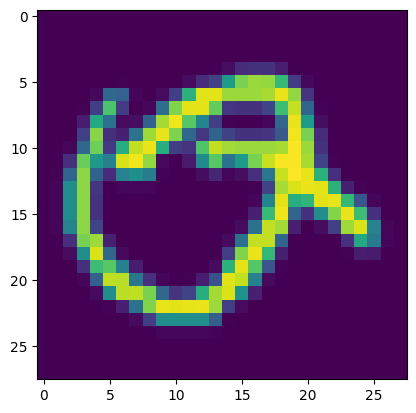

In [31]:
n = 3
plt.imshow(X_test[n])
y_test[n]

In [32]:
def flip_and_rotate(images):
    return np.array([np.rot90(np.fliplr(image.reshape(28, 28))).reshape(28, 28, 1) for image in images])

In [33]:
X_train = flip_and_rotate(X_train)
X_test = flip_and_rotate(X_test)

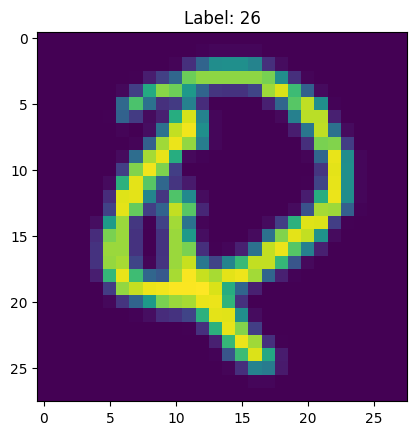

In [34]:
n = 3
plt.imshow(X_test[n])
plt.title(f"Label: {y_test[n]}")
plt.show()

In [35]:
# Convolutional Neural Network
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(47, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 207s 58ms/step - accuracy: 0.5114 - loss: 1.7090 - val_accuracy: 0.8273 - val_loss: 0.5116
Epoch 2/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 203s 57ms/step - accuracy: 0.7614 - loss: 0.7376 - val_accuracy: 0.8459 - val_loss: 0.4514
Epoch 3/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 193s 55ms/step - accuracy: 0.7942 - loss: 0.6268 - val_accuracy: 0.8564 - val_loss: 0.4146
Epoch 4/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 179s 51ms/step - accuracy: 0.8042 - loss: 0.5918 - val_accuracy: 0.8609 - val_loss: 0.3963
Epoch 5/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 190s 54ms/step - accuracy: 0.8141 - loss: 0.5482 - val_accuracy: 0.8625 - val_loss: 0.3882


In [36]:
y_pred = cnn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cnn_acc = accuracy_score(y_test, y_pred_labels)

print("CNN Accuracy: %.2f%%" % (cnn_acc * 100))

588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
CNN Accuracy: 86.25%


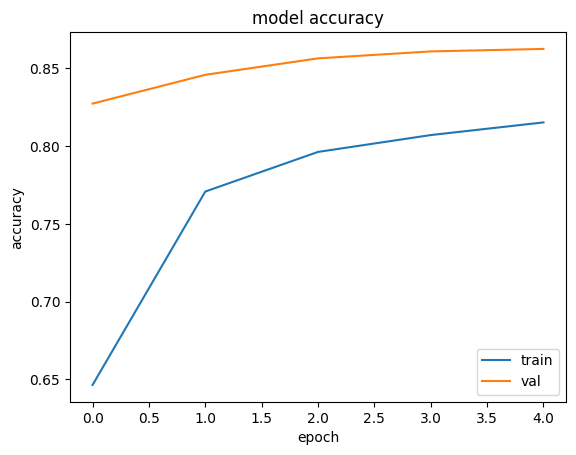

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

588/588 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step


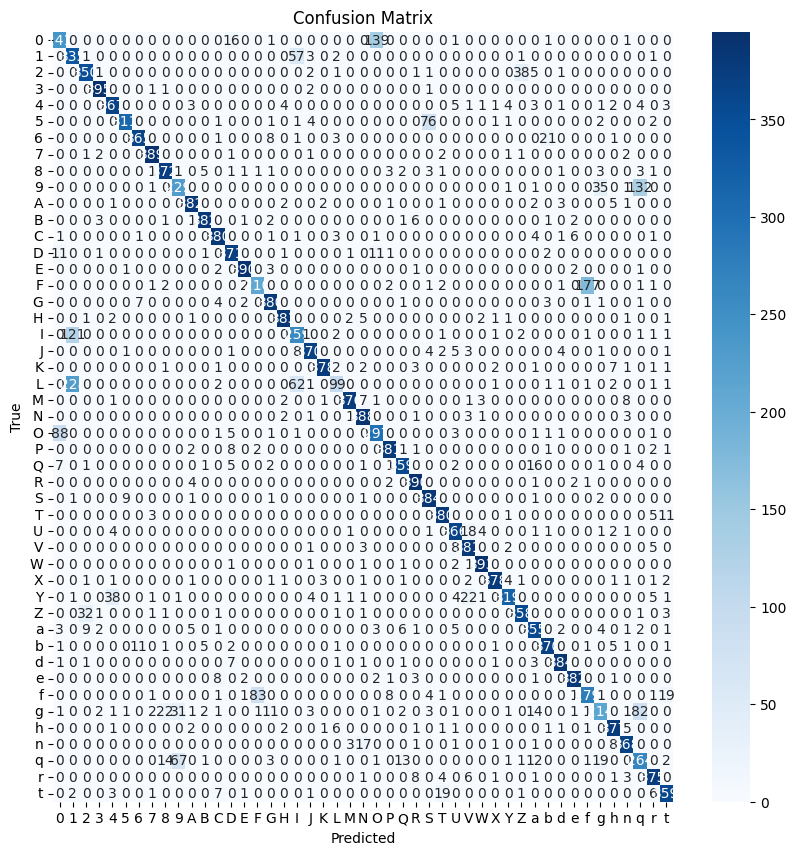

In [50]:
class_labels = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

prob=cnn.predict(X_test)
y_pred=np.argmax(prob,axis=-1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, [class_labels[i] for i in range(len(class_labels))])
plt.yticks(tick_marks + 0.5, [class_labels[i] for i in range(len(class_labels))])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 47)                  │           6,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 689,423 (2.63 MB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 459,616 (1.75 MB)

In [42]:
len(cnn.layers)

10

In [39]:
cnn.save('cnn.h5')

In [40]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(cnn, '/content')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
from tensorflow.keras.models import load_model
model_loaded = load_model('cnn_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_loaded.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_loaded.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1)

3525/3525 ━━━━━━━━━━━━━━━━━━━━ 213s 59ms/step - accuracy: 0.8261 - loss: 0.5093 - val_accuracy: 0.8709 - val_loss: 0.3704


In [ ]:
y_pred = model_loaded.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cnn_acc = accuracy_score(y_test, y_pred_labels)

print("CNN Accuracy: %.2f%%" % (cnn_acc * 100))

588/588 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
CNN Accuracy: 87.09%


In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_loaded, '/content')

failed to lookup keras version from the file,
    this is likely a weight only file
